In [68]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import matplotlib.animation as animation
from os import listdir
from tqdm.notebook import tqdm as t

data_dir = "/home/pau/Documents/DataHotIPs/"

files = sorted(listdir(data_dir))

#Parameters of the grid
Ntimes = 119
N = 80
#Change line below to name of the files
namefile = lambda i,j: data_dir + 'source_'+str(i)+'_'+str(j)+'.npy'

In [60]:
def weighted_norm(Sigma_inv, x):
    return x.T@Sigma_inv@x

def compute_posterior(true_source, measurement_array, Sigma_noise, preload_data = None, preload_measurements = None):

    if preload_data is None:
        #Generate random data
        True_measurements = np.load(namefile(*true_source))[measurement_array]
        noise = np.random.multivariate_normal(mean = [0]*n_measurements, cov = Sigma_noise)
        data = True_measurements + noise
    else: 
        data = preload_data
    
    if preload_measurements is None:
        #Will load the matrices from disk
        get_measurements = lambda i,j: np.load(namefile(i,j))[measurement_array]
    else:
        #Measurements has to be (N,N,N_measurements)
        get_measurements = lambda i,j: preload_measurements[i,j]
  
    
    Sigma_inv = np.linalg.inv(Sigma_noise)
    posterior = np.zeros((N,N))
    #I'm not sure if this can be vectorized anymore since I have to individually open and close files
    #However, it is not slow
    for i in t(range(N)):
        for j in range(N):
            #Compute prob(data|source is in (i,j))
            #Compute first true observations that would have happened if the source was in (i,j)
            hypothetical_observations = get_measurements(i,j)
            posterior[i,j] = np.exp(-1/2 * weighted_norm(Sigma_inv, data-hypothetical_observations))
    s = np.sum(posterior)
    posterior/= s
    return posterior

In [70]:
#Example parameters to run the function
true_source = (3,7) #Specifies the coordinate in the grid where one can find the true source 
#Where in the grid are we making measurements? 
#We specify it with a boolean array of shape [Ntimes, N, N], true if we are making measurements and false if not
#The following example is 10 sensors in the diagonal at all times, giving us 10*10*119 = 1190 measurements
measurement_array = np.zeros((Ntimes, N, N)).astype(bool)
sensors = [[6*i, 6*i] for i in range(1,11)]
n_measurements = 0
for i in range(Ntimes):
    for sensor in sensors:
        measurement_array[i, sensor[0], sensor[1]] = True
        n_measurements +=1

In [69]:
#An example of precomputed measurements: 
precomputed_measurements = np.zeros((N,N,n_measurements))
for i in t(range(N)):
    for j in range(N):
        precomputed_measurements[i,j] = np.load(namefile(i,j))[measurement_array]

  0%|          | 0/80 [00:00<?, ?it/s]

In [75]:
sigma = 0.1 
Sigma_noise = sigma**2*np.eye(n_measurements) #Assuming here that all the sensors are independent and with the same noise

In [76]:
posterior = compute_posterior(true_source=true_source, measurement_array=measurement_array, Sigma_noise=Sigma_noise, 
                 preload_measurements= precomputed_measurements)

  0%|          | 0/80 [00:00<?, ?it/s]

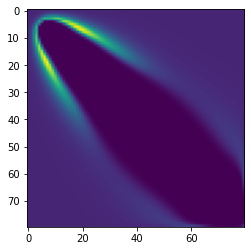

In [77]:
plt.imshow(posterior)